In [1]:
# %load processData.py
# Need to take the transpose of the getStocks data and return a CSV with the values.
# Need to also consider cases when there is missing stock data if any (median filling or whatever).

import glob, os
import re
import pandas as pd
import zipfile
from datetime import datetime
import numpy as np
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt


# %load convexOptUtils.py
# Utilities for mean-variance portfolio convex optimization

def getReturns(quoteTable):
    rTable = []
    vecRep = quoteTable.values.tolist()
    shiftVecRep = quoteTable.values.tolist()
    del shiftVecRep[0]
    for i in range(len(shiftVecRep)):
        quoteVec = np.array(shiftVecRep[i][1:])
        previousQuoteVec = np.array(vecRep[i][1:])
        diffVec = [shiftVecRep[i][0]] + list(quoteVec - previousQuoteVec)
        rTable.append(diffVec)
    
    returnsTable = pd.DataFrame(rTable, columns=quoteTable.columns)
    return returnsTable

def getMeanCov(returnsTable):
    desc = returnsTable.describe()
    mVector = []
    for i in desc.columns.tolist():
        mVector.append(desc[i]['mean'])
    return (np.array(mVector), np.cov(np.array(returnsTable[[x for x in returnsTable.columns if x != 'DATE']]).T))


def getPortfolio(mVector, covMatrix, mode=0):
    # Mode 0: Minimize risk and maximize return
    # Mode 1: Minimize risk exclusively
    # Mode 2: Maximize return exclusively

    # Cost function is w^T(Cov)w - w^T(Mean)
    # We are solving 1/2w^T(Cov)w + (Mean)^Tw
    # Subject to Gw <= H and Aw = b
    # Constraints on w are w >= 0 and w < 1 and sum(w) = 1

    if mode == 0:
        P = matrix(list(map(lambda x: list(x), list(covMatrix * 2.0))))
        q = matrix(list(map(lambda x: x * -1.0, list(mVector))))
    elif mode == 1:
        P = matrix(list(map(lambda x: list(x), list(covMatrix * 2.0))))
        q = matrix(list(np.zeros(len(mVector))))
    elif mode == 2:
        P = matrix(list(map(lambda x: list(x), list(np.zeros((len(mVector), len(mVector)))))))
        q = matrix(list(map(lambda x: x * -1.0, list(mVector))))

    G = []
    H = []
    for k in range(len(mVector)):
        tmp = [0]*(2*len(mVector)) # w_i >= 0 and w_i < 1 makes it two constraints per asset.
        tmp[2*k] = -1.0 # 
        tmp[2*k + 1] = 1.0
        G.append(tmp)
    
    for k in range(2*len(mVector)):
        if k % 2 == 0:
            H.append(0.0)
        else:
            H.append(1.0)

    H = matrix(H)
    G = matrix(G)

    A = matrix([[1.0]]*len(mVector))
    b = matrix(1.0)
    
    solvers.options['show_progress'] = False
    sol = solvers.qp(P, q, G, H, A, b)

    return list(map(lambda x: round(x, 4), list(sol['x'])))


def getPortfolioBounded(mVector, covMatrix, bound):
    P = matrix(list(map(lambda x: list(x), list(covMatrix * 2.0))))
    q = matrix(list(np.zeros(len(mVector))))
    
    G = []
    H = []
    for k in range(len(mVector)):
        tmp = [0]*(2*len(mVector)) # w_i >= 0 and w_i < 1 makes it two constraints per asset.
        tmp[2*k] = -1.0 # 
        tmp[2*k + 1] = 1.0
        tmp.append(-1.0*mVector[k])
        G.append(tmp)
        
    for k in range(2*len(mVector)):
        if k % 2 == 0:
            H.append(0.0)
        else:
            H.append(1.0)

    H.append(-1.0*bound)
    
    H = matrix(H)
    G = matrix(G)

    A = matrix([[1.0]]*len(mVector))
    b = matrix(1.0)
    
    solvers.options['show_progress'] = False
    sol = solvers.qp(P, q, G, H, A, b)

    return list(map(lambda x: round(x, 4), list(sol['x'])))
    

def plotMarkowitz(N_iter, mean, cov):
    # Monte-carlo generation of the Markowitz-Pareto boundary.
    # Will return the statistical risk averse and maximum return portfolio.
    stoch = np.random.rand(N_iter, len(mean))
    stoch = stoch/stoch.sum(axis=1)[:,None].tolist()

    exp_return = []
    exp_volatility = []
    wvec = []

    for i in stoch:
        exp_return.append(np.dot(i, mean))
        exp_volatility.append(np.sqrt(np.dot(i, np.dot(cov, np.transpose(i)))))
        wvec.append(i)

    plt.scatter(exp_volatility, exp_return)
    plt.savefig("MarkowitzPareto.png")

    riskAversePortfolio = stoch[exp_volatility.index(min(exp_volatility))]
    maxReturnPortfolio = stoch[exp_return.index(max(exp_return))]

    return riskAversePortfolio, maxReturnPortfolio 

##USE FOR NSE BHAVCOPY DATABASES
##OBSOLETE DUE TO THE DATASET BEING UNADJUSTED TO DIVIDENDS/SPLIT
def extractData():
    for file in glob.glob("stockData/*.zip"):
        print("processData is extracting " + file)
        with zipfile.ZipFile(file, 'r') as zip_ref:
            zip_ref.extractall("./stockData")

def unifyCSV(columns_to_extract):
    stockDF = pd.DataFrame(columns = columns_to_extract)
    for file in glob.glob("stockData/*.csv"):
        tmp = pd.read_csv(file)
        print("processData is unifying: " + file)
        stockDF = stockDF.append(tmp[columns_to_extract])

    return stockDF

def getQuoteTable(symbols, stockDF, params=[]):
    if symbols == "ALL":
        symbols = list(set(stockDF['SYMBOL'].tolist()))
    table_columns = ['DATE']
    for i in symbols:
        table_columns = table_columns + [str(i)]
    quoteTable = pd.DataFrame(columns=table_columns)
    stockAgg = []
    for x in list(map(lambda y: y.strftime('%d-%b-%Y').upper(), sorted(list(map(lambda x: datetime.strptime(x, '%d-%b-%Y'), list(set(stockDF['TIMESTAMP']))))))):
        row = []
        print("getQuoteTable is processing timestamp: " + str(x))
        row.append(x)
        for j in [y for y in quoteTable.columns if y != 'DATE']:
            residue = stockDF[(stockDF['SYMBOL'] == j) & (stockDF['SERIES'] == 'EQ') & (stockDF['TIMESTAMP'] == x)]['CLOSE'].tolist()
            print("getQuoteTable found " + str(len(residue)) + " entries for symbol: " + str(j) + " with timestamp: " + str(x))
            if len(residue) == 0:
                residue = np.NaN
            else:
                residue = residue[0]
            row.append(residue)
        stockAgg.append(row)
    quoteTable = pd.DataFrame(stockAgg, columns = table_columns)
    quoteTable.fillna(0, inplace=True)
    print("getQuoteTable is saving quoteTable.csv")
    quoteTable.to_csv("quoteTable.csv", index=False, na_rep=np.NaN)
    return quoteTable

def getQuoteTableV2(symlist, stockDF, params=[]):
    
    symbols = sorted(symlist)
    
    subsetDF = pd.DataFrame([], columns=stockDF.columns.tolist())
    for sym in symbols:
        subsetDF = subsetDF.append(stockDF[stockDF['SYMBOL'] == sym])
    
    tstamps = list(map(lambda y: y.strftime('%d-%b-%Y').upper(), \
                       sorted( \
                              list(set \
                                   (list(map(lambda x: datetime.strptime(x, '%d-%b-%Y'), \
                                             subsetDF['TIMESTAMP'].tolist())))))))
    
    
    table_columns = ['DATE']
    for i in symbols:
        table_columns = table_columns + [str(i)]
    quoteDF = []
    
    for t in tstamps:
        tmpDF = subsetDF[subsetDF['TIMESTAMP'] == t]
        for s in symbols:
            if len(tmpDF[tmpDF['SYMBOL'] == s]) == 0:
                tmpDF = tmpDF.append(pd.DataFrame([[s, 'EQ', t] + 4*[0.0]], columns=tmpDF.columns.tolist()))
        tmpDF = tmpDF.sort_values(by="SYMBOL")
        tmpAppend = [t]
        for index, row in tmpDF.iterrows():
            tmpAppend.append(row['CLOSE'])
        quoteDF.append(tmpAppend)

    quoteDF = pd.DataFrame(quoteDF, columns=table_columns)
    quoteDF.fillna(0, inplace=True)
    print("getQuoteTable is saving quoteTable.csv")
    quoteDF.to_csv("quoteTable.csv", index=False, na_rep=np.NaN)
    return quoteDF


# Usage
# extractData()
# stockDF = unifyCSV(["SYMBOL", "SERIES", "TIMESTAMP", "OPEN", "HIGH", "LOW", "CLOSE"])
# qTable = getQuoteTable(["EVEREADY","EICHERMOT","SUNTV","SUNPHARMA","ASHIANA","EMAMILTD","CLNINDIA","CADILAHC","THYROCARE","BLUEDART","HINDZINC"], 
#                         stockDF)

In [2]:
qTable = pd.read_csv("stockDataGoogleFinance.csv")

# We will pad the NaNs after removing the intermittent shares
print(qTable.isnull().values.any())

for c in qTable.columns.tolist():
    if qTable[c][0] == 0:
        print("Dropping " + str(c) + " due to empty start price.")
        qTable.drop(c, axis=1, inplace=True)

qTable.interpolate(inplace=True, method='cubic')

print(qTable.isnull().values.any())
qTable

True
Dropping THYROCARE due to empty start price.
Dropping ALKEM due to empty start price.
Dropping NSE:LALPATHLAB due to empty start price.
Dropping NSE:MGL due to empty start price.
Dropping NSE:DMART due to empty start price.
Dropping NSE:KPITTECH due to empty start price.
False


,DATE,EVEREADY,EICHERMOT,SUNTV,NSE:IOC,ASHIANA,EMAMILTD,SUNPHARMA,ONGC,CLNINDIA,...,JUNIORBEES,NIFTYBEES,NSE:HINDALCO,JUBLFOOD,NSE:N100,GOLDBEES,NSE:NOIDATOLL,NSE:SAIL,NSE:VEDL,NSE:WABCOINDIA
0,1/1/2014,36.05,4982.85,367.25,51.45,71.10,240.95,573.85,187.80,612.00,...,130.97,62.86,120.65,639.63,220.90,27.46,21.75,71.10,199.85,1986.85
1,1/2/2014,36.05,4968.95,370.25,50.86,71.70,240.33,579.70,183.87,602.30,...,128.09,62.79,118.75,629.48,225.86,27.65,21.85,70.65,199.15,2010.95
2,1/3/2014,36.45,4985.95,377.10,51.14,72.25,238.08,588.25,187.30,598.90,...,129.93,62.54,118.25,624.85,223.55,27.63,21.75,72.05,198.95,1994.25
3,1/4/2014,36.45,4985.95,377.10,51.14,72.25,238.08,588.25,187.30,598.90,...,129.93,62.54,118.25,624.85,223.55,27.63,21.75,72.05,198.95,1994.25
4,1/5/2014,36.45,4985.95,377.10,51.14,72.25,238.08,588.25,187.30,598.90,...,129.93,62.54,118.25,624.85,223.55,27.63,21.75,72.05,198.95,1994.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2236,2/15/2020,68.80,18535.90,473.60,111.80,106.00,284.35,408.40,99.95,361.50,...,293.40,127.84,190.25,1833.05,682.95,35.93,3.85,42.80,142.10,6806.55
2237,2/16/2020,68.80,18535.90,473.60,111.80,106.00,284.35,408.40,99.95,361.50,...,293.40,127.84,190.25,1833.05,682.95,35.93,3.85,42.80,142.10,6806.55
2238,2/17/2020,68.05,18760.35,471.75,112.65,105.50,274.05,408.65,99.30,357.50,...,292.05,127.34,184.35,1832.40,674.64,36.14,3.70,41.95,140.55,6797.60
2239,2/18/2020,68.25,18875.20,495.10,114.20,105.05,272.55,403.55,101.70,360.75,...,297.98,128.59,188.10,1897.60,676.71,36.71,3.65,41.65,142.65,6725.20


In [3]:
qTable.describe()

,EVEREADY,EICHERMOT,SUNTV,NSE:IOC,ASHIANA,EMAMILTD,SUNPHARMA,ONGC,CLNINDIA,CADILAHC,...,JUNIORBEES,NIFTYBEES,NSE:HINDALCO,JUBLFOOD,NSE:N100,GOLDBEES,NSE:NOIDATOLL,NSE:SAIL,NSE:VEDL,NSE:WABCOINDIA
count,2241.000000,2241.000000,2241.000000,2241.000000,2241.000000,2241.000000,2241.000000,2241.000000,2241.000000,2241.000000,...,2241.000000,2241.000000,2241.000000,2241.000000,2241.000000,2241.000000,2241.000000,2241.000000,2241.000000,2241.000000
mean,215.512822,20288.107359,543.954009,133.511048,154.259241,459.343770,650.879637,180.003096,621.565068,342.306823,...,236.683581,95.949252,171.929682,879.645617,389.138225,27.117701,17.624388,61.107037,202.581429,5680.545133
std,106.339537,6882.253896,199.975536,43.260588,42.850619,119.301713,173.387575,40.070674,191.602100,85.491497,...,53.962403,18.036013,53.006185,362.668362,129.139783,2.713175,10.269469,15.901268,68.725720,1392.066603
min,34.650000,4417.800000,258.050000,48.880000,71.100000,214.750000,366.800000,99.300000,269.250000,156.150000,...,118.900000,60.830000,60.850000,392.630000,207.150000,22.490000,2.700000,30.050000,61.650000,1739.700000
25%,103.600000,16416.150000,376.150000,96.610000,120.000000,357.900000,507.850000,151.270000,440.200000,271.800461,...,194.237567,81.810000,135.500000,586.900000,280.000000,25.480000,9.250000,48.250000,155.650000,5375.400000
50%,235.900000,20321.150000,472.104482,133.450000,153.850000,501.450000,626.035672,172.550000,642.000000,348.900000,...,239.490000,89.738878,181.650000,748.300000,369.050000,26.740000,13.800000,59.200000,199.650000,6048.300000
75%,287.262089,25331.300000,706.900000,163.450000,176.750000,550.300000,803.500000,197.400000,756.900000,394.050000,...,286.280000,111.840000,210.550000,1215.180000,504.930000,28.010000,24.850000,73.500000,249.750000,6477.850000
max,456.150000,32861.950000,1079.150000,227.350000,306.550000,668.200000,1169.300000,310.430000,1164.300000,549.150000,...,324.590000,131.190000,279.800000,1955.400000,686.250000,36.820000,36.950000,109.900000,345.600000,8284.550000


In [4]:
rTable = getReturns(qTable)
rTable

,DATE,EVEREADY,EICHERMOT,SUNTV,NSE:IOC,ASHIANA,EMAMILTD,SUNPHARMA,ONGC,CLNINDIA,...,JUNIORBEES,NIFTYBEES,NSE:HINDALCO,JUBLFOOD,NSE:N100,GOLDBEES,NSE:NOIDATOLL,NSE:SAIL,NSE:VEDL,NSE:WABCOINDIA
0,1/2/2014,0.00,-13.90,3.00,-0.59,0.60,-0.62,5.85,-3.93,-9.70,...,-2.88,-0.07,-1.90,-10.15,4.96,0.19,0.10,-0.45,-0.70,24.10
1,1/3/2014,0.40,17.00,6.85,0.28,0.55,-2.25,8.55,3.43,-3.40,...,1.84,-0.25,-0.50,-4.63,-2.31,-0.02,-0.10,1.40,-0.20,-16.70
2,1/4/2014,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,1/5/2014,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,1/6/2014,0.60,7.15,-2.95,-1.20,2.20,0.80,5.95,-3.13,13.20,...,-1.47,-0.15,-2.20,-3.65,0.43,-0.02,-0.20,-2.30,-4.45,-23.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,2/15/2020,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2236,2/16/2020,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2237,2/17/2020,-0.75,224.45,-1.85,0.85,-0.50,-10.30,0.25,-0.65,-4.00,...,-1.35,-0.50,-5.90,-0.65,-8.31,0.21,-0.15,-0.85,-1.55,-8.95
2238,2/18/2020,0.20,114.85,23.35,1.55,-0.45,-1.50,-5.10,2.40,3.25,...,5.93,1.25,3.75,65.20,2.07,0.57,-0.05,-0.30,2.10,-72.40


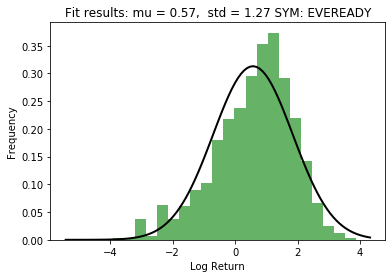

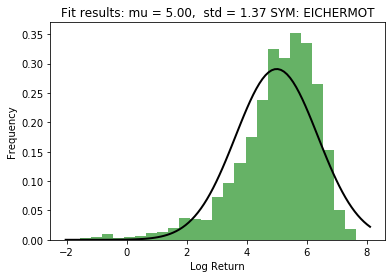

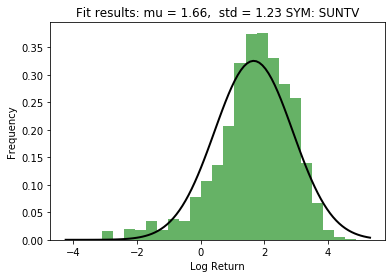

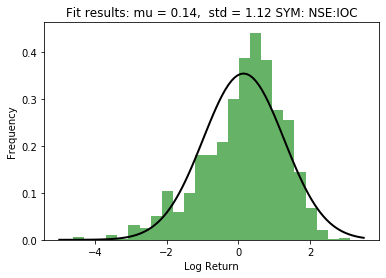

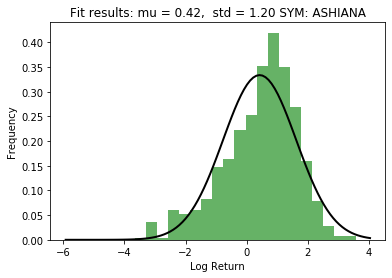

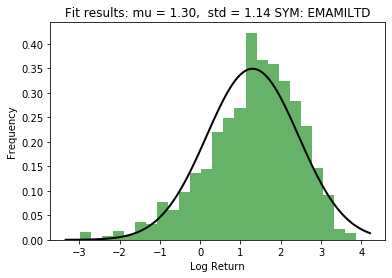

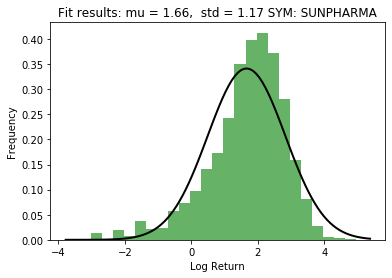

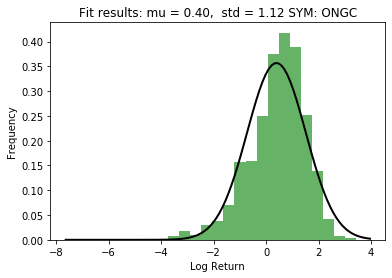

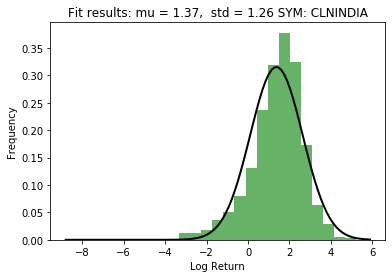

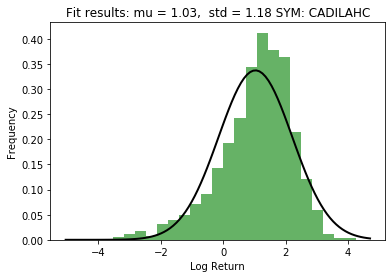

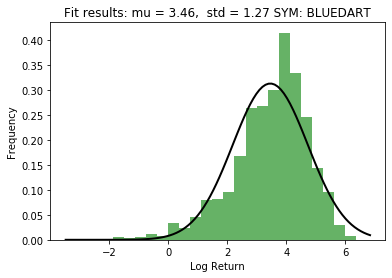

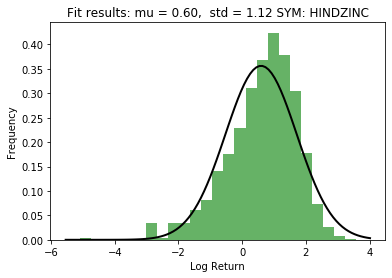

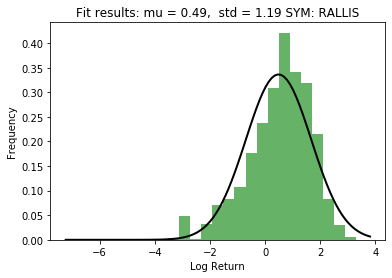

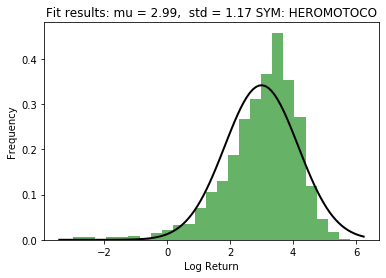

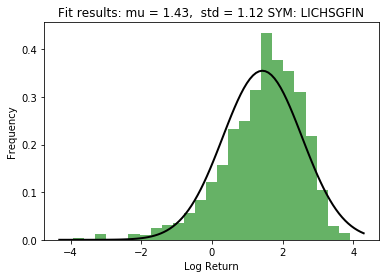

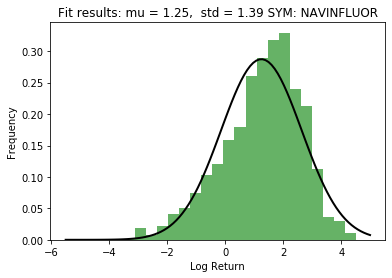

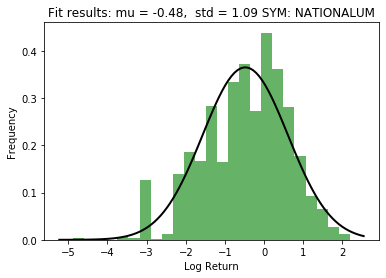

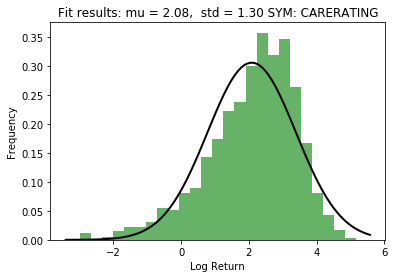

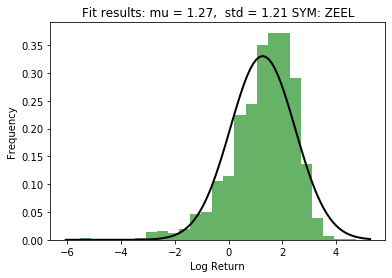

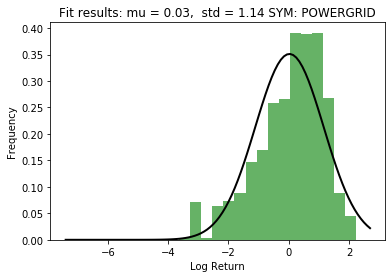

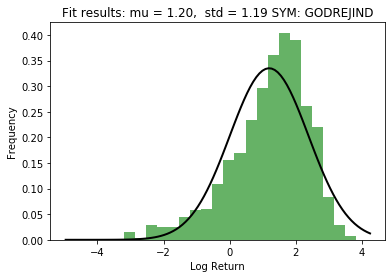

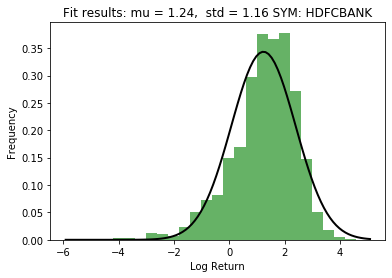

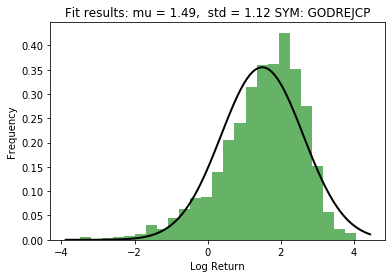

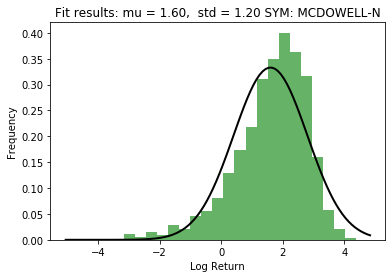

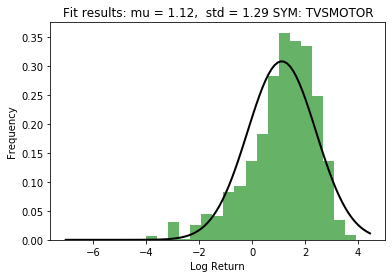

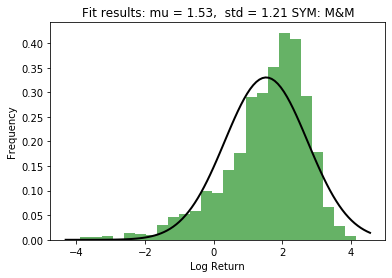

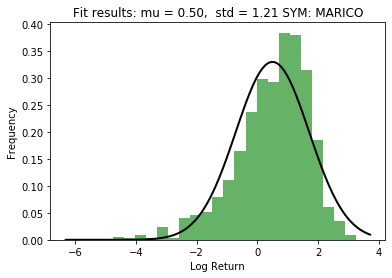

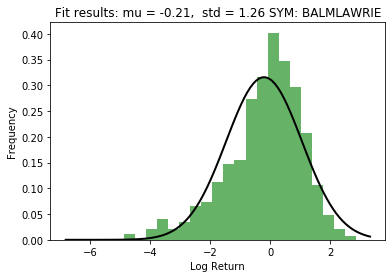

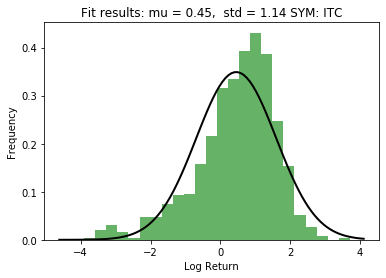

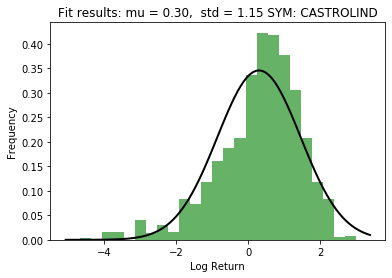

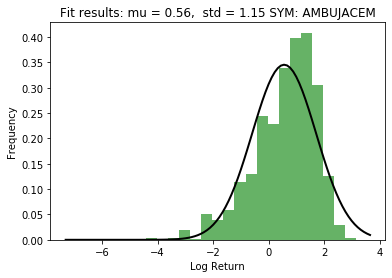

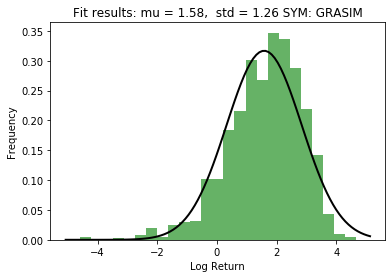

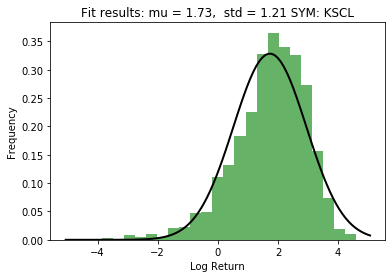

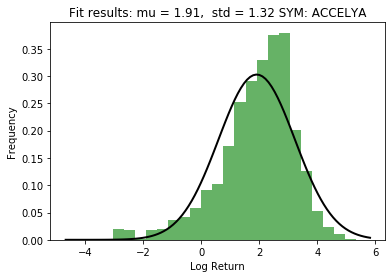

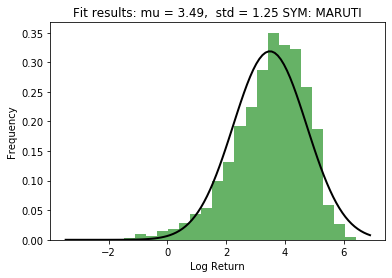

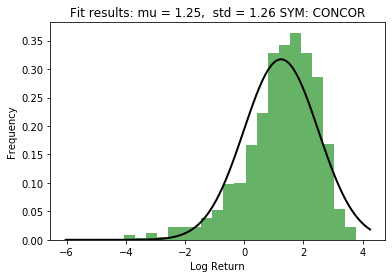

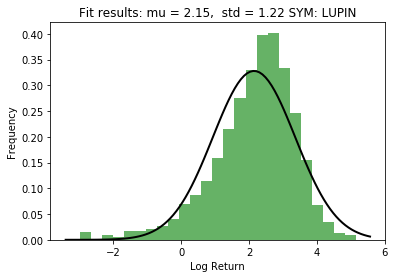

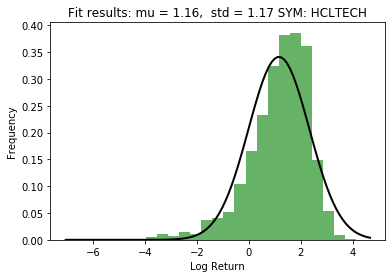

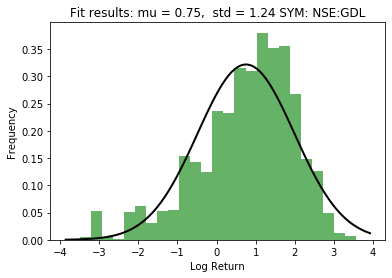

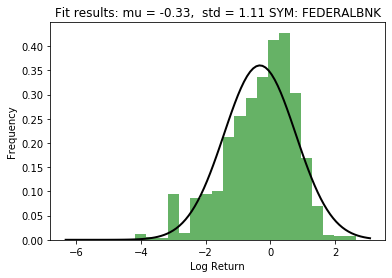

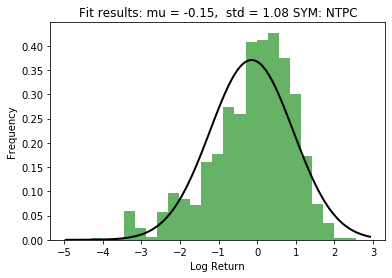

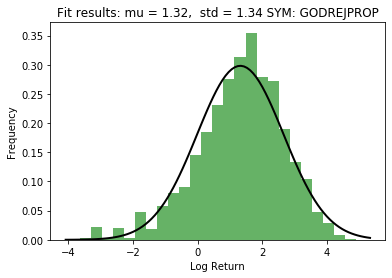

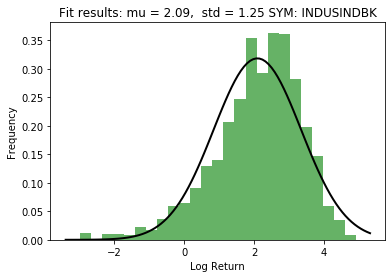

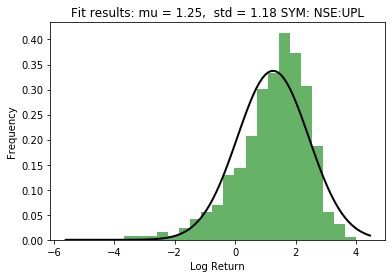

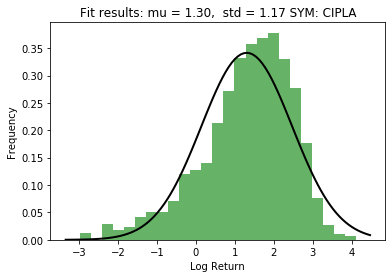

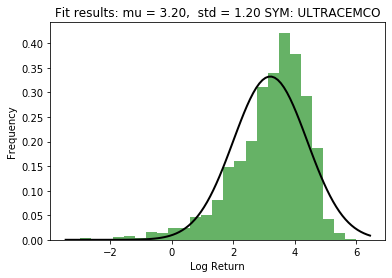

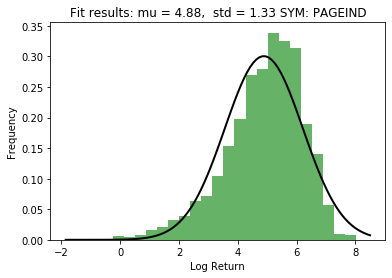

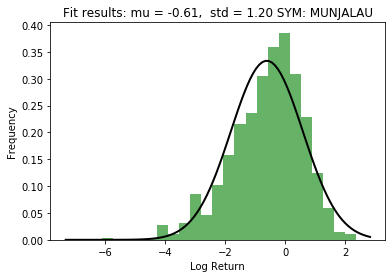

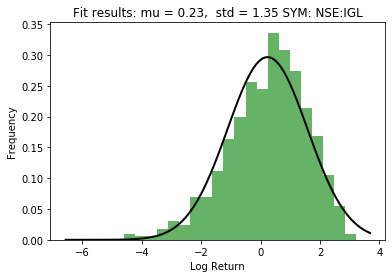

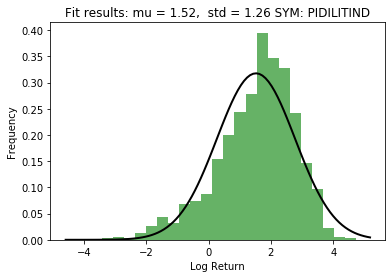

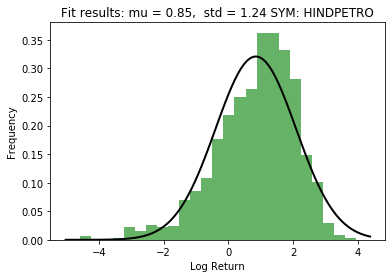

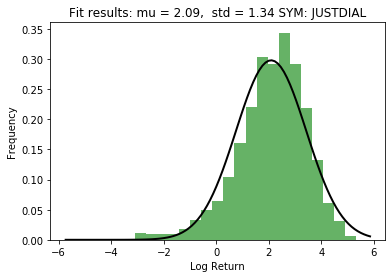

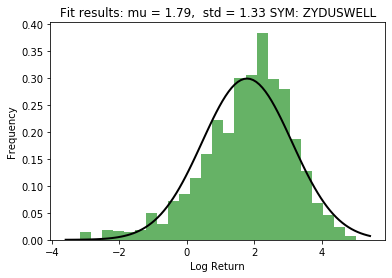

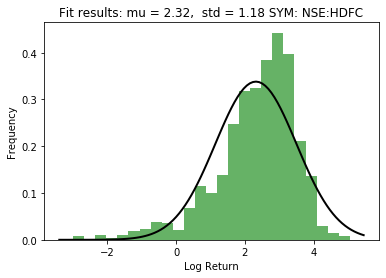

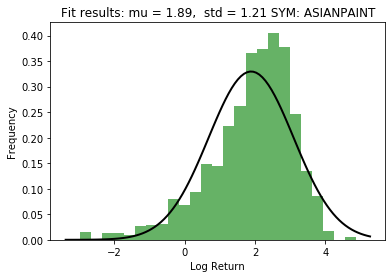

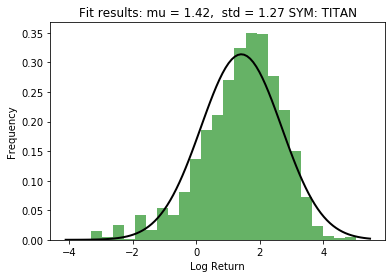

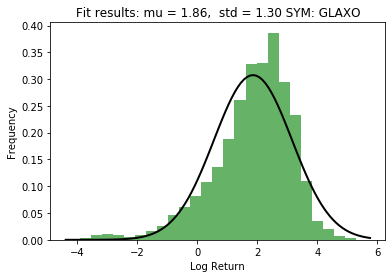

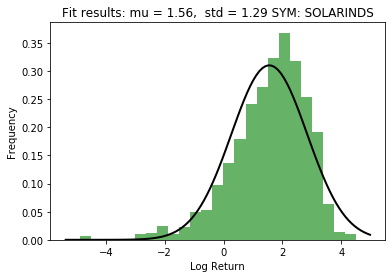

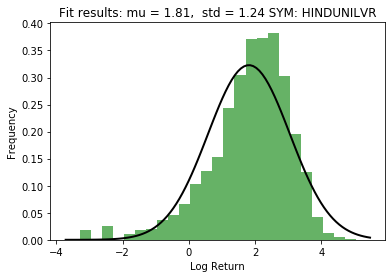

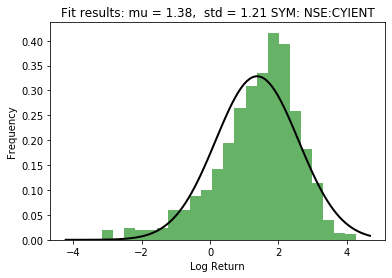

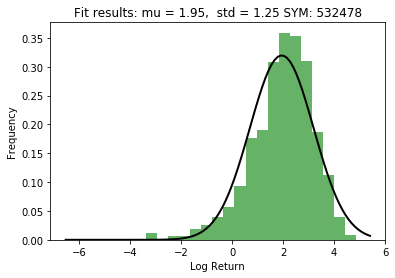

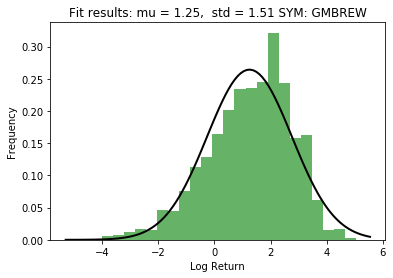

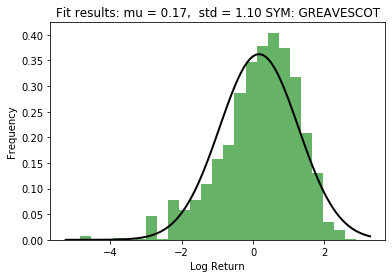

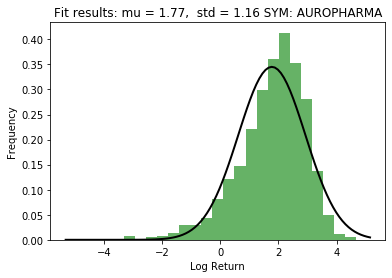

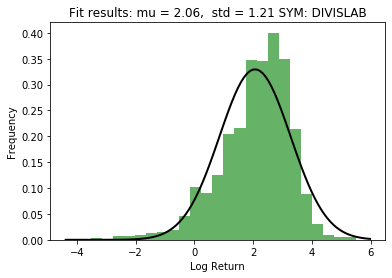

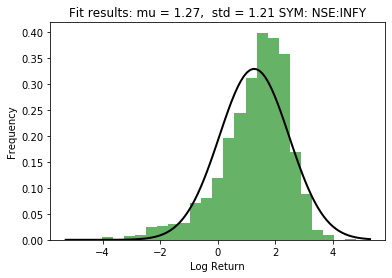

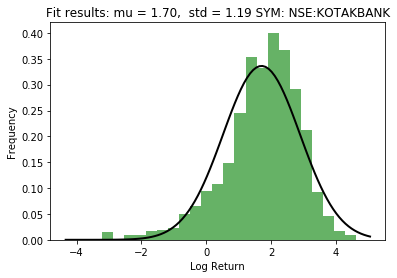

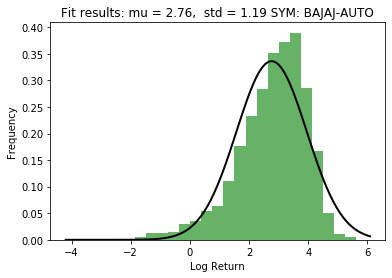

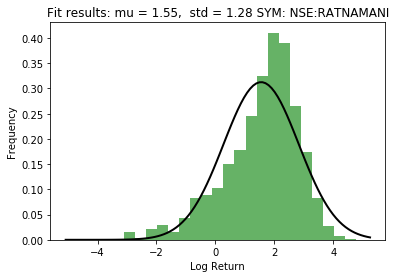

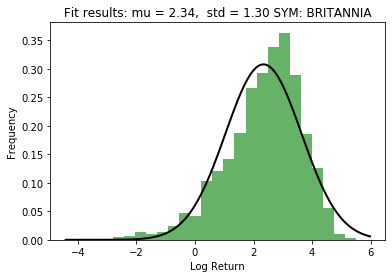

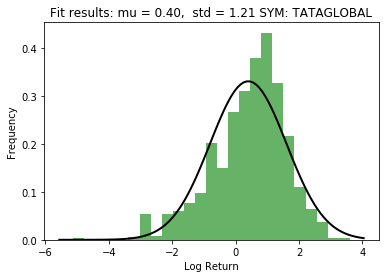

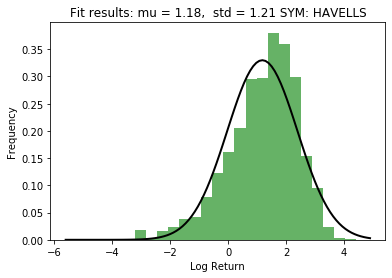

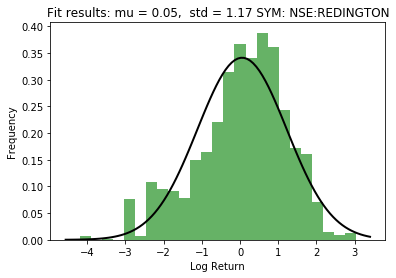

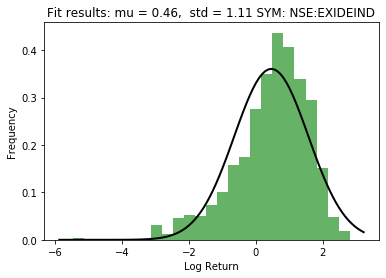

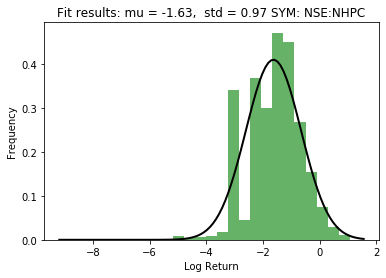

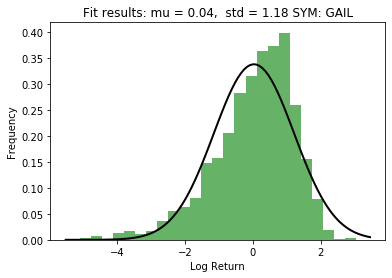

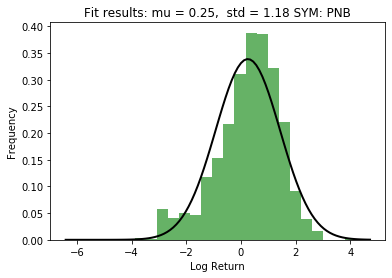

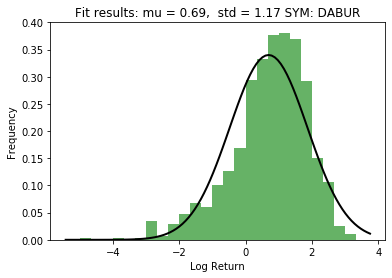

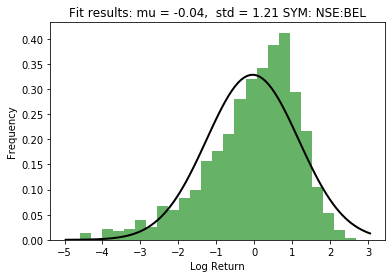

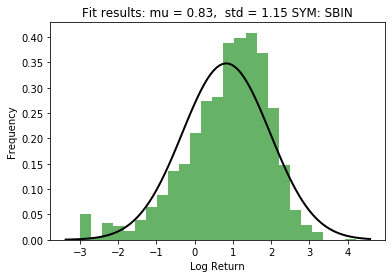

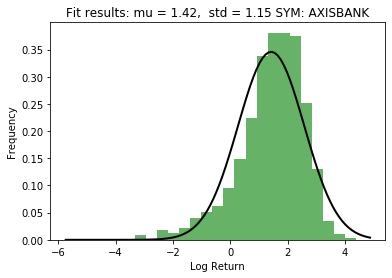

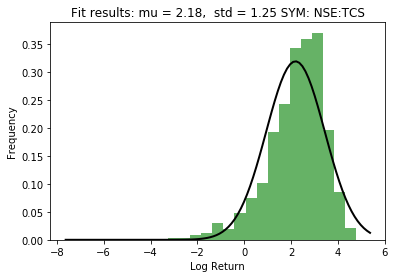

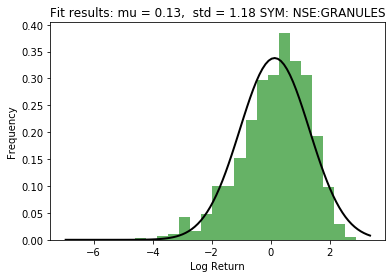

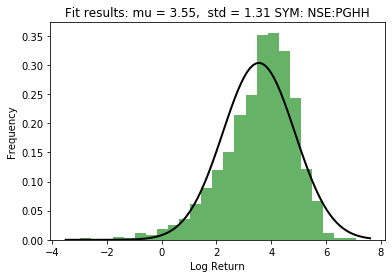

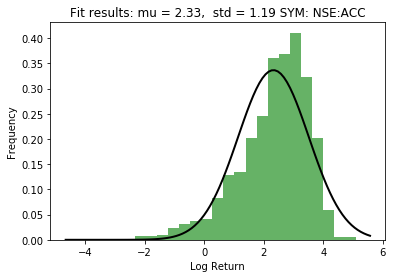

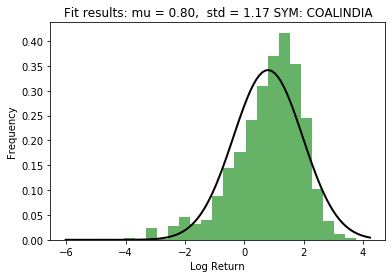

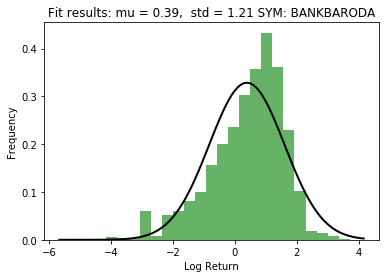

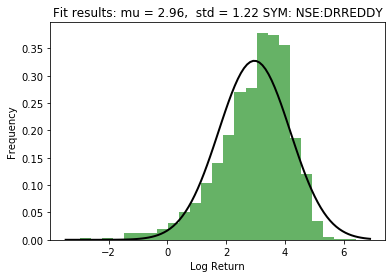

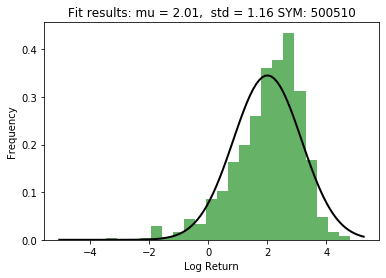

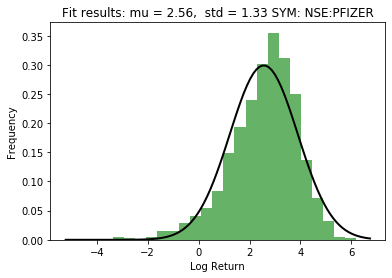

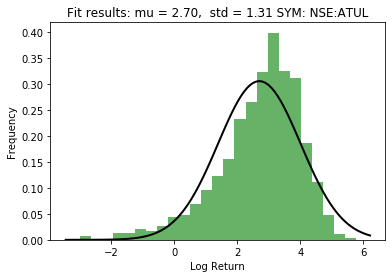

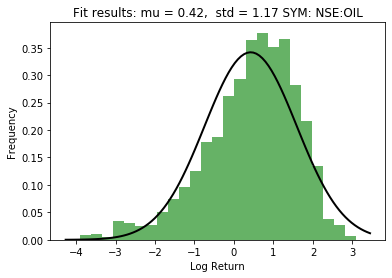

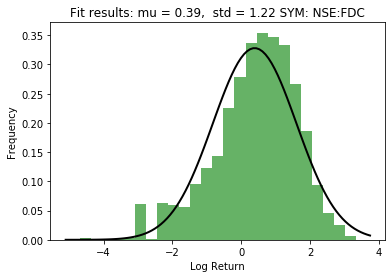

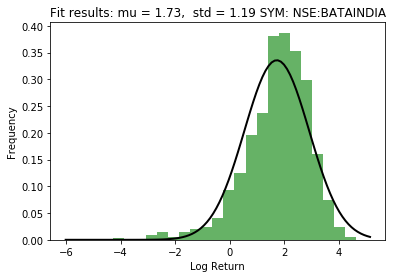

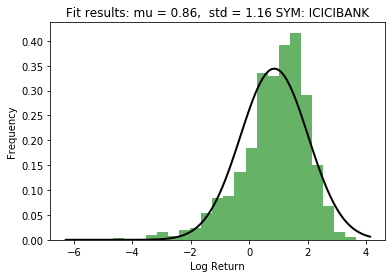

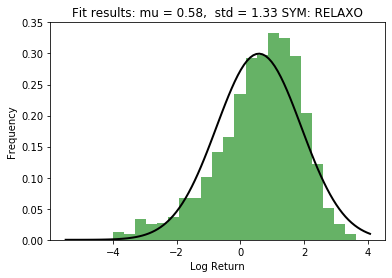

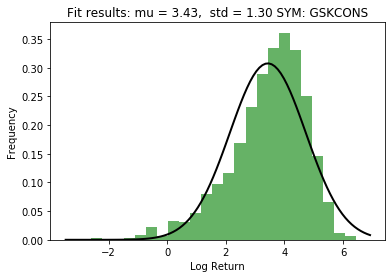

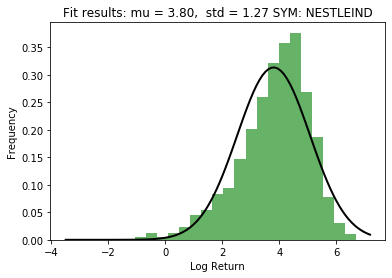

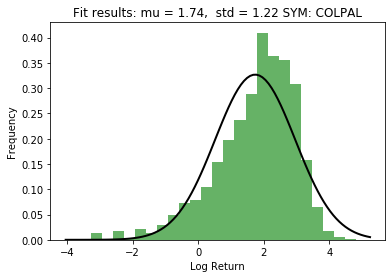

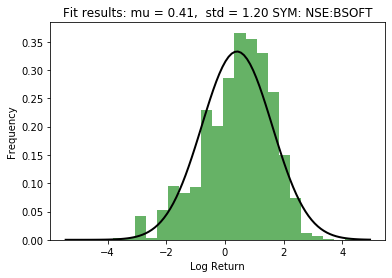

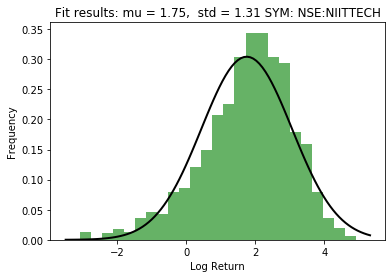

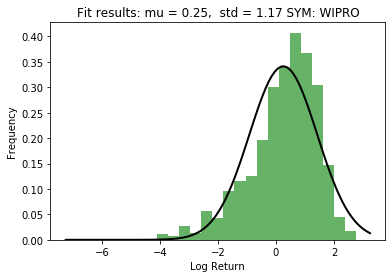

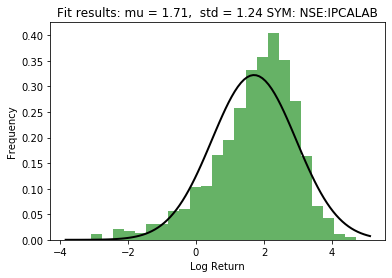

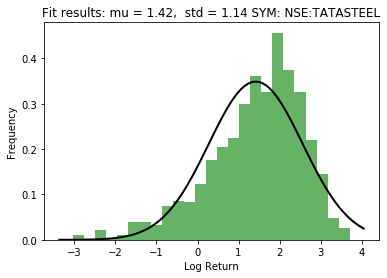

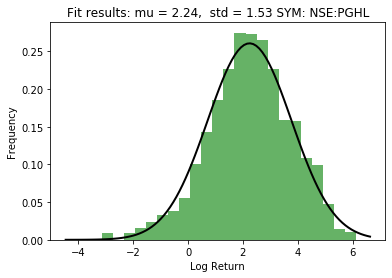

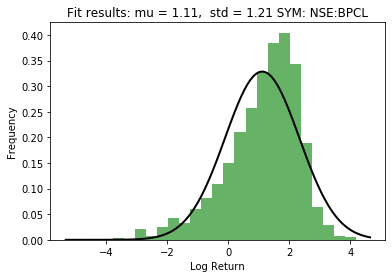

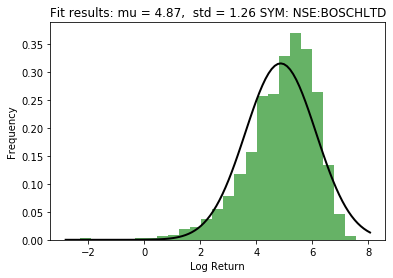

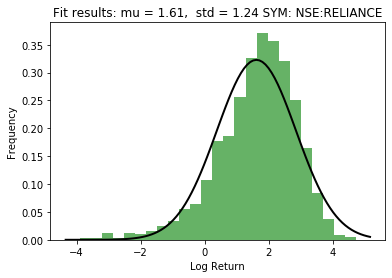

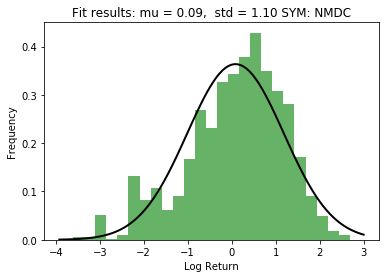

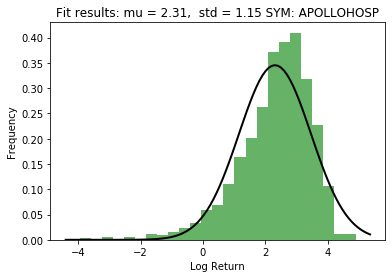

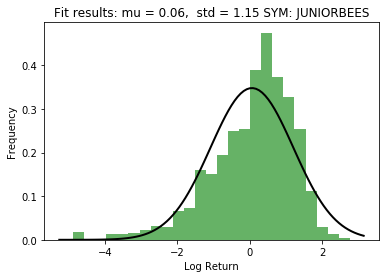

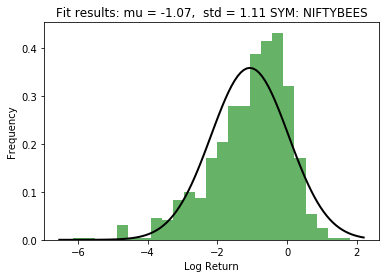

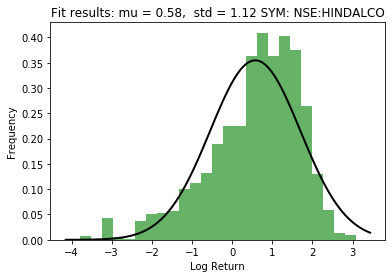

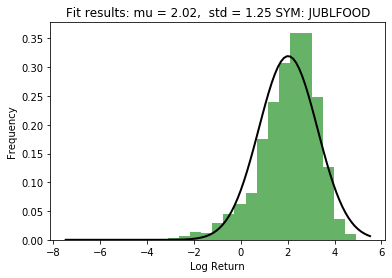

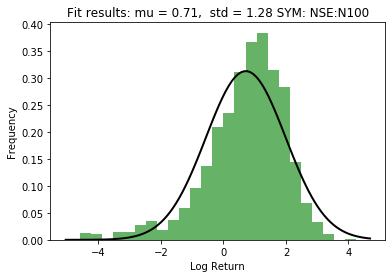

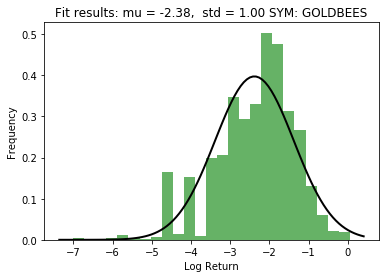

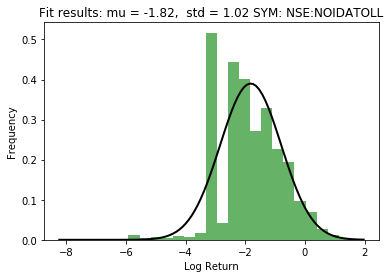

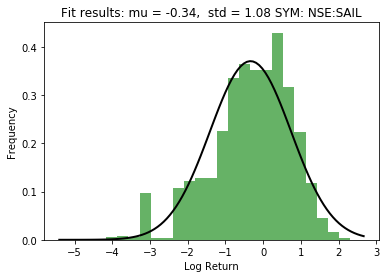

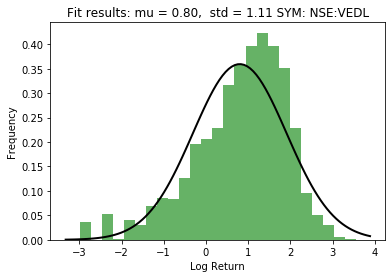

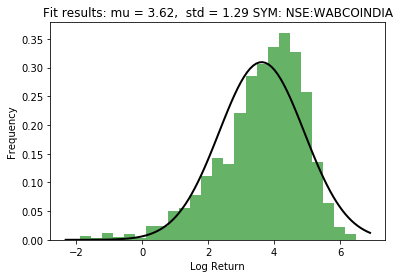

In [5]:
from scipy.stats import norm

for k in rTable.columns.tolist():
    if k != "DATE":
        data = list( \
                    map( \
                        lambda x: np.log(np.abs(x)), \
                        list( \
                            filter( \
                                lambda t: round(t, 5) != 0, \ 
                                    rTable[k].tolist()))))

        mu, std = norm.fit(data)

        # Plot the histogram.
        plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

        # Plot the PDF.
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        plt.plot(x, p, 'k', linewidth=2)
        title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
        plt.title(title + " SYM: " + str(k))
        plt.xlabel("Log Return")
        plt.ylabel("Frequency")
        plt.show()

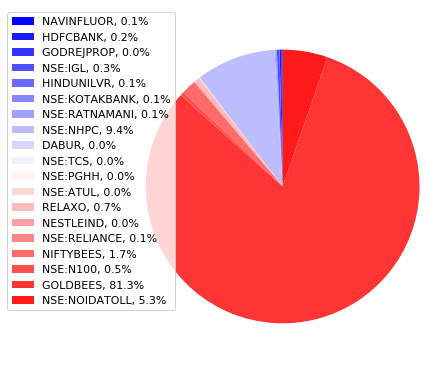

In [6]:
mean, cov = getMeanCov(rTable)
z_total = getPortfolio(mean, cov, mode=0)
distr = list(filter(lambda t: t[0] != 0.0, list(zip(z_total, rTable.columns.tolist()[1:]))))

labels = list(map(lambda t: t[1], distr))
sizes = list(map(lambda t: t[0], distr))

fig1, ax1 = plt.subplots(figsize=(6, 5))
fig1.subplots_adjust(0.3,0,1,1)


theme = plt.get_cmap('bwr')
ax1.set_prop_cycle("color", [theme(1. * i / len(sizes)) for i in range(len(sizes))])

_, _ = ax1.pie(sizes, startangle=90)

ax1.axis('equal')

total = sum(sizes)
plt.legend(
    loc='upper left',
    labels=['%s, %1.1f%%' % (
        l, (float(s) / total) * 100) for l, s in zip(labels, sizes)],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
)

plt.show()


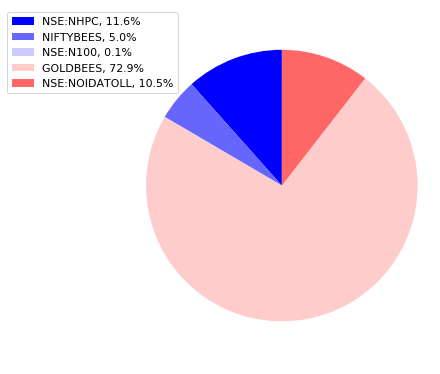

In [7]:
z_ra = getPortfolio(mean, cov, mode=1)
distr = list(filter(lambda t: t[0] != 0.0, list(zip(z_ra, rTable.columns.tolist()[1:]))))

labels = list(map(lambda t: t[1], distr))
sizes = list(map(lambda t: t[0], distr))

fig1, ax1 = plt.subplots(figsize=(6, 5))
fig1.subplots_adjust(0.3,0,1,1)


theme = plt.get_cmap('bwr')
ax1.set_prop_cycle("color", [theme(1. * i / len(sizes)) for i in range(len(sizes))])

_, _ = ax1.pie(sizes, startangle=90)

ax1.axis('equal')

total = sum(sizes)
plt.legend(
    loc='upper left',
    labels=['%s, %1.1f%%' % (
        l, (float(s) / total) * 100) for l, s in zip(labels, sizes)],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
)

plt.show()

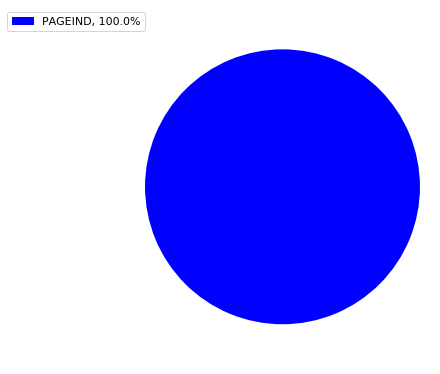

In [8]:
z_return_only = getPortfolio(mean, cov, mode=2)
distr = list(filter(lambda t: t[0] != 0.0, list(zip(z_return_only, rTable.columns.tolist()[1:]))))

labels = list(map(lambda t: t[1], distr))
sizes = list(map(lambda t: t[0], distr))

fig1, ax1 = plt.subplots(figsize=(6, 5))
fig1.subplots_adjust(0.3,0,1,1)


theme = plt.get_cmap('bwr')
ax1.set_prop_cycle("color", [theme(1. * i / len(sizes)) for i in range(len(sizes))])

_, _ = ax1.pie(sizes, startangle=90)

ax1.axis('equal')

total = sum(sizes)
plt.legend(
    loc='upper left',
    labels=['%s, %1.1f%%' % (
        l, (float(s) / total) * 100) for l, s in zip(labels, sizes)],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
)

plt.show()

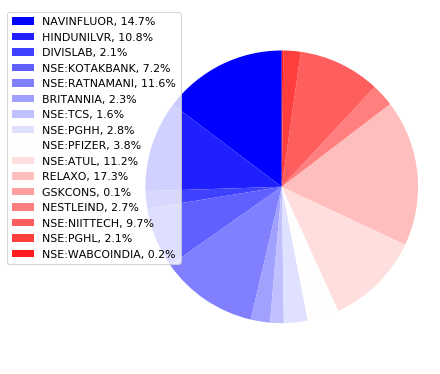

In [66]:
solvers.options['abstol'] = 1e-7

# w1, w2, w3, w4, w5 
# a1*w1 + a2*w2 + ... >= 0

z_return_bounded = getPortfolioBounded(mean, cov, 1)
distr = list(filter(lambda t: t[0] != 0.0, list(zip(z_return_bounded, rTable.columns.tolist()[1:]))))

labels = list(map(lambda t: t[1], distr))
sizes = list(map(lambda t: t[0], distr))

fig1, ax1 = plt.subplots(figsize=(6, 5))
fig1.subplots_adjust(0.3,0,1,1)


theme = plt.get_cmap('bwr')
ax1.set_prop_cycle("color", [theme(1. * i / len(sizes)) for i in range(len(sizes))])

_, _ = ax1.pie(sizes, startangle=90)

ax1.axis('equal')

total = sum(sizes)
plt.legend(
    loc='upper left',
    labels=['%s, %1.1f%%' % (
        l, (float(s) / total) * 100) for l, s in zip(labels, sizes)],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
)

plt.show()

1.0


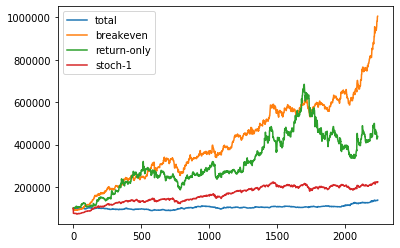

Average		Final
104786.31	139036.34
164785.81	164785.81
417291.32	1004690.35
318548.75	438428.8


In [68]:
def simulatePortfolio(weights, qTable, initCapital, debug=False):
    #Purchase takes place on the first timestamp and tracking of portfolio value takes place henceforth
    purchaseAmount = list(map(lambda t: initCapital*t, weights))
    priceArray = qTable.loc[0].tolist()[1:]
    unitsPurchased = list(map(lambda t: int(t[0]/t[1]), list(zip(purchaseAmount, priceArray))))
    portfolioValue = [initCapital]
    for index, row in qTable.iterrows():
        if index == 0:
            continue
        else:
            priceArrayTmp = qTable.loc[index].tolist()[1:]
            portfolioValue.append(sum(list(map(lambda t: t[0]*t[1], list(zip(unitsPurchased, priceArrayTmp))))))
            if debug:
                print("Value on date: " + str(row['DATE']) + " is : " + str(sum(list(map(lambda t: t[0]*t[1], list(zip(unitsPurchased, priceArrayTmp)))))))
                print("Distribution: " + str(list(map(lambda t: t[0]*t[1], list(zip(unitsPurchased, priceArrayTmp))))))

    return portfolioValue

# We can plot the porfolio value versus other stochastic vectors that can be generated
original = simulatePortfolio(z_total, qTable, 100000)
plt.plot(list(range(len(original))), original, label="total")

bounded = simulatePortfolio(z_return_bounded, qTable, 100000)
return_only = simulatePortfolio(z_return_only, qTable, 100000)
plt.plot(list(range(len(bounded))), bounded, label="breakeven")
plt.plot(list(range(len(return_only))), return_only, label="return-only")
print(sum(z_return_bounded))

# We need to generate stochastic row vectors. 
N_iter = 1
stoch = []
for i in range(N_iter):
    tmpRandom = np.random.rand(1, len(z_total)).tolist()[0]
    stoch.append(list(map(lambda z: z/sum(tmpRandom), tmpRandom)))

idx = 0
mArray = []
for i in stoch:
    idx = idx + 1
    tmp = simulatePortfolio(i, qTable, 100000)
    plt.plot(list(range(len(tmp))), tmp, label="stoch-"+str(idx))
    mArray.append(np.mean(tmp))
plt.legend(loc="upper left")
plt.show()
print("Average\t\tFinal")
print(str(round(np.mean(original), 2)) + "\t" + str(round(original[-1], 2)))
print(str(round(np.mean(mArray), 2)) + "\t" + str(round(mArray[-1], 2)))
print(str(round(np.mean(bounded), 2)) + "\t" + str(round(bounded[-1], 2)))
print(str(round(np.mean(return_only), 2)) + "\t" + str(round(return_only[-1], 2)))

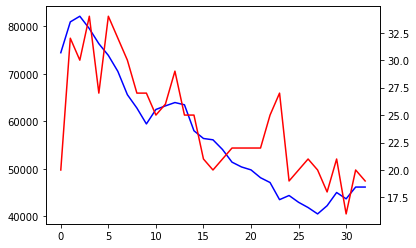

In [169]:
# How about we adjust the weights every week?
# We start with an initial random vector and tweak it
# by solving the convex optimization problem iteratively.

w = np.random.rand(1, len(z_total)).tolist()[0]

w = np.array(list(map(lambda t: t/sum(w), w)))

capital = 100000
portfolioValue = []
weightVectors = []
window = 70

for k in range(len(qTable)):
    # We will use this initial random vector and evolve over the window of time to get our capital for iteration
    
    if window*k > len(qTable):
        break
    try:
        tmpTable = qTable[window*k:window*(k+1)]
        # Obviously, after every evolution we can store the data for our own optimization purposes.
        storeTable = qTable[0:window*(k+1)]

        tmpTable.reset_index(inplace=True, drop=True)
        storeTable.reset_index(inplace=True, drop=True)

        # Evolve the capital, w pair over the duration of the window to obtain end of window valuation
        capital = simulatePortfolio(w, tmpTable, capital)[-1]

        # Weight vector changes => sell/buy calls ???
        
        # Using the stored data (along with the data of the current window), optimize new weights for risk aversion.
        rTableTmp = getReturns(storeTable)
        meanTmp, covTmp = getMeanCov(rTableTmp)
        w = getPortfolio(meanTmp, covTmp, 0)
        weightVectors.append(w)
        portfolioValue.append(capital)
        
    except:
        break
    
    if capital == 0:
        break
    
znorm = list(map(lambda t: len([i for i in t if i != 0]), weightVectors))
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(list(range(len(portfolioValue))), np.array(portfolioValue), 'b-')
ax2.plot(list(range(len(portfolioValue))), znorm, 'r-')
plt.show()

In [167]:
portfolioValue

[144889.15455675547, 164680.64377841857, 191146.85, 203105.12]

In [168]:
assetTracker = list(map(lambda t: list(zip(\
                        [qTable.columns.tolist()[1:][t.index(i)] for i in t if i != 0],\
                         [i for i in t if i != 0])), weightVectors))
assetTracker[-1]

[('NAVINFLUOR', 0.0015),
 ('HDFCBANK', 0.002),
 ('GODREJPROP', 0.0002),
 ('NSE:IGL', 0.0031),
 ('HINDUNILVR', 0.0006),
 ('NSE:KOTAKBANK', 0.0009),
 ('NSE:RATNAMANI', 0.0013),
 ('NSE:NHPC', 0.094),
 ('DABUR', 0.0001),
 ('NSE:TCS', 0.0004),
 ('DABUR', 0.0001),
 ('GODREJPROP', 0.0002),
 ('RELAXO', 0.0067),
 ('DABUR', 0.0001),
 ('NSE:RELIANCE', 0.0008),
 ('NIFTYBEES', 0.0172),
 ('NSE:N100', 0.0047),
 ('GOLDBEES', 0.8131),
 ('NSE:NOIDATOLL', 0.053)]

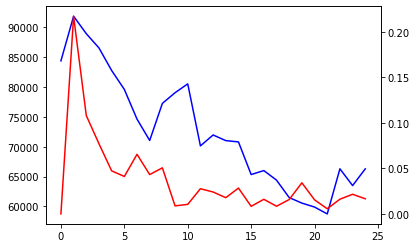

In [98]:
wDiff = [0.0]
for i in range(1, len(weightVectors)):
    wDiff.append(np.linalg.norm(np.array(weightVectors[i]) - np.array(weightVectors[i-1])))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(list(range(len(portfolioValue))), np.array(portfolioValue), 'b-')
ax2.plot(list(range(len(portfolioValue))), wDiff, 'r-')
plt.show()

In [132]:
def findBreakEven(window, qTable, N, capital):
    w = np.random.rand(1, N).tolist()[0]
    w = np.array(list(map(lambda t: t/sum(w), w)))
    portfolioValue = []
    weightVectors = []

    for k in range(len(qTable)):
        if window*k > len(qTable):
            break
        try:
            tmpTable = qTable[window*k:window*(k+1)]
            storeTable = qTable[0:window*(k+1)]
            tmpTable.reset_index(inplace=True, drop=True)
            storeTable.reset_index(inplace=True, drop=True)
            capital = simulatePortfolio(w, tmpTable, capital)[-1]
            rTableTmp = getReturns(storeTable)
            meanTmp, covTmp = getMeanCov(rTableTmp)
            w = getPortfolio(meanTmp, covTmp, 0)
            weightVectors.append(w)
            portfolioValue.append(capital)
        except:
            break

        if capital == 0:
            break
    
    znorm = list(map(lambda t: len([i for i in t if i != 0]), weightVectors))
    return portfolioValue

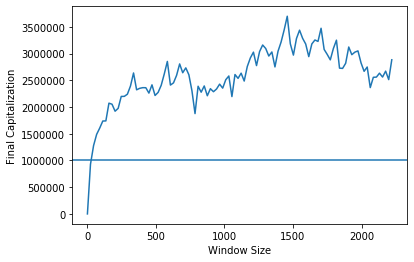

In [200]:
finalPosition = []
windowArray = []
for win in np.linspace(3, 2220, 100):
    pValFinal = findBreakEven(int(win), qTable, len(z_total), 1000000)
    windowArray.append(win)
    finalPosition.append(pValFinal[-1])
    
plt.plot(windowArray, finalPosition)
plt.xlabel("Window Size")
plt.ylabel("Final Capitalization")
plt.axhline(y=1000000)
plt.show()

In [193]:
# Clearly, there are random choices of portfolios that make more end balance
# However, the average value of the portfolio is within 10% of the risk averse structure.

# We need to make buy/sell/hold calls at the right time stamps to accelerate this average.

# The idea behind making these decisions comes from the HJB-Koopman formalism. We need a factor for each asset
# that gives us the overall growth trend. In the dynamic systems lingo, this is the Lyapunov exponent.

# Let us take the first 6 stock symbols as a test-case to develop this framework.

import copy

expT = copy.deepcopy(qTable)
expT.index = expT['DATE']
expT = np.array(expT.drop(['DATE'], axis=1).T.values.tolist())

# We define the contraction operator

contract = lambda t: np.array(t[0].T.tolist()[t[1]-1:t[2]]).T

X1 = contract((expT, 1, len(expT[0])-1))

# We perform full SVD on the matrix.
print("Rank: " + str(np.linalg.matrix_rank(X1)))
U, S, VH = np.linalg.svd(X1, full_matrices=True)
S_diag = np.zeros((U.shape[1], VH.shape[0]))
np.fill_diagonal(S_diag, S)
print(np.allclose(expTContracted - np.dot(U, np.dot(S_diag, VH)), 1e-15))
print(U.shape, S_diag.shape, VH.shape)

Rank: 120
True
(120, 120) (120, 2240) (2240, 2240)


In [224]:
# The Koopman evolution in the Krylov subspace should be equivalent to shifting the contraction
# forwards by one day per application of the Hamilton-Koopman operator

# That is, X2 = AX1
# => X2 = A . (U . S . VH)
# => UH . A . U = UH . X2 . V . S^{-1}

# UH . A. U  is a similarity transformation for A which ensures 
# that the eigenspectrum is consistent.

# There are two clear issues here. We can never truly get the Koopman operator but only 
# upto a similarity transformation. Therefore, the Koopman operator can only be ascertained
# or is unique upto the eigenspace.

# Second issue is that we need the singular value diagonal matrix to be invertible to
# obtain the similar matrix. Therefore, we need to pick the rank contracted approximation
# of the SVD, a la Eckart-Young.

X2 = contract((expT, 2, len(expT[0])))
A_similar = np.dot(U.T, np.dot(X2, np.dot(VH.T, np.linalg.pinv(S_diag))))
eigval, eigvec = np.linalg.eig(A_similar)
eigzip = list(zip(range(len(eigval)), eigval.real))
eigzip.sort(key=lambda t: t[1], reverse=True)
indices = list(map(lambda t: t[0], eigzip))
for idx in indices:
    print(qTable.columns.tolist()[1:][idx])

NSE:TCS
BANKBARODA
NSE:PFIZER
NSE:ATUL
NSE:DRREDDY
500510
NSE:FDC
NSE:BATAINDIA
NSE:OIL
NESTLEIND
COLPAL
WIPRO
NSE:IPCALAB
NSE:ACC
COALINDIA
NSE:TATASTEEL
NSE:PGHL
NSE:BSOFT
NSE:NIITTECH
NSE:GRANULES
NSE:PGHH
JUBLFOOD
NSE:N100
SBIN
AXISBANK
RELAXO
GSKCONS
NSE:RELIANCE
NMDC
NSE:EXIDEIND
NSE:NHPC
GAIL
PNB
APOLLOHOSP
JUNIORBEES
GOLDBEES
NSE:NOIDATOLL
NSE:KOTAKBANK
BAJAJ-AUTO
NSE:SAIL
NSE:VEDL
DABUR
NSE:BEL
NIFTYBEES
NSE:HINDALCO
NSE:CYIENT
532478
DIVISLAB
NSE:INFY
HAVELLS
NSE:REDINGTON
NSE:WABCOINDIA
NSE:HDFC
ASIANPAINT
MUNJALAU
NSE:IGL
NSE:BPCL
NSE:BOSCHLTD
TITAN
GLAXO
ICICIBANK
PIDILITIND
HINDPETRO
GMBREW
GREAVESCOT
BRITANNIA
TATAGLOBAL
GODREJPROP
INDUSINDBK
NSE:RATNAMANI
NSE:UPL
CIPLA
JUSTDIAL
ZYDUSWELL
AUROPHARMA
ACCELYA
MARUTI
SOLARINDS
HINDUNILVR
ULTRACEMCO
PAGEIND
CASTROLIND
AMBUJACEM
CONCOR
LUPIN
FEDERALBNK
NTPC
HCLTECH
NSE:GDL
TVSMOTOR
M&M
GRASIM
KSCL
BALMLAWRIE
ITC
MARICO
GODREJCP
MCDOWELL-N
ZEEL
POWERGRID
RALLIS
HEROMOTOCO
GODREJIND
HDFCBANK
LICHSGFIN
NAVINFLUOR
NATIONALUM
CARE

In [226]:
indices

[81,
 86,
 89,
 90,
 87,
 88,
 92,
 93,
 91,
 97,
 98,
 101,
 102,
 84,
 85,
 103,
 104,
 99,
 100,
 82,
 83,
 113,
 114,
 79,
 80,
 95,
 96,
 107,
 108,
 73,
 74,
 75,
 76,
 109,
 110,
 115,
 116,
 66,
 67,
 117,
 118,
 77,
 78,
 111,
 112,
 59,
 60,
 64,
 65,
 71,
 72,
 119,
 53,
 54,
 47,
 48,
 105,
 106,
 55,
 56,
 94,
 49,
 50,
 61,
 62,
 69,
 70,
 41,
 42,
 68,
 43,
 44,
 51,
 52,
 63,
 33,
 34,
 57,
 58,
 45,
 46,
 29,
 30,
 35,
 36,
 39,
 40,
 37,
 38,
 24,
 25,
 31,
 32,
 27,
 28,
 26,
 22,
 23,
 18,
 19,
 12,
 13,
 20,
 21,
 14,
 15,
 16,
 17,
 8,
 9,
 10,
 11,
 4,
 5,
 6,
 7,
 2,
 3,
 0,
 1]